In [1]:
import torch
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from src.dataset import get_robustness_loader
from src.models import get_model

# Define evaluation functions
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    return acc, f1

def run_robustness_test(model, data_dir, device, batch_size=32):
    results = []
    
    # Clean Baseline
    print("Evaluating on Clean Test Set...")
    clean_loader = get_robustness_loader(data_dir, degradation=None, batch_size=batch_size)
    clean_acc, clean_f1 = evaluate_model(model, clean_loader, device)
    results.append({
        'Condition': 'Clean',
        'Parameter': 'None',
        'Accuracy': clean_acc,
        'F1-Score': clean_f1
    })
    
    # Gaussian Noise
    sigmas = [0.1, 0.5, 1.0]
    for sigma in sigmas:
        print(f"Evaluating Gaussian Noise (sigma={sigma})...")
        loader = get_robustness_loader(data_dir, degradation={'type': 'noise', 'params': {'std': sigma}}, batch_size=batch_size)
        acc, f1 = evaluate_model(model, loader, device)
        results.append({
            'Condition': 'Gaussian Noise',
            'Parameter': f'sigma={sigma}',
            'Accuracy': acc,
            'F1-Score': f1
        })
        
    # Blur
    kernels = [3, 5, 7]
    for k in kernels:
        print(f"Evaluating Blur (kernel={k})...")
        loader = get_robustness_loader(data_dir, degradation={'type': 'blur', 'params': {'kernel_size': k}}, batch_size=batch_size)
        acc, f1 = evaluate_model(model, loader, device)
        results.append({
            'Condition': 'Blur',
            'Parameter': f'k={k}',
            'Accuracy': acc,
            'F1-Score': f1
        })
        
    # Contrast
    factors = [0.3, 0.5, 0.8]
    for f in factors:
        print(f"Evaluating Contrast (factor={f})...")
        loader = get_robustness_loader(data_dir, degradation={'type': 'contrast', 'params': {'factor': f}}, batch_size=batch_size)
        acc, f1 = evaluate_model(model, loader, device)
        results.append({
            'Condition': 'Contrast',
            'Parameter': f'factor={f}',
            'Accuracy': acc,
            'F1-Score': f1
        })
        
    df = pd.DataFrame(results)
    
    # Calculate drops relative to clean
    df['Acc Drop'] = clean_acc - df['Accuracy']
    df['F1 Drop'] = clean_f1 - df['F1-Score']
    
    return df

In [2]:
# Configuration
DATA_DIR = './classification_task'
NUM_CLASSES = 4
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_config = [
    {'name': 'custom_cnn', 'path': 'custom_cnn_best.pt'},
    {'name': 'resnet50', 'path': 'resnet50_best.pt'},
    {'name': 'vit_b_16', 'path': 'vit_b_16_best.pt'},
    {'name': 'yolov8_cls', 'path': 'yolov8_cls_best.pt'}
]

all_results = {}

for config in models_config:
    model_name = config['name']
    model_path = config['path']
    
    print(f"\n{'='*20}")
    print(f"Processing Model: {model_name}")
    print(f"Loading weights from: {model_path}")
    
    try:
        # Initialize model architecture
        model = get_model(model_name, NUM_CLASSES, pretrained=False)
        
        # Load weights
        if os.path.exists(model_path):
            state_dict = torch.load(model_path, map_location=DEVICE)
            model.load_state_dict(state_dict)
            model.to(DEVICE)
            print("Model loaded successfully.")
            
            # Run robustness test
            df_results = run_robustness_test(model, DATA_DIR, DEVICE, batch_size=BATCH_SIZE)
            all_results[model_name] = df_results
            
            print(f"Results for {model_name}:")
            display(df_results)
            
            # Save individual results
            output_csv = f"{model_name}_stress_test_results.csv"
            df_results.to_csv(output_csv, index=False)
            print(f"Saved results to {output_csv}")
            
        else:
            print(f"Error: Checkpoint file {model_path} not found!")
            
    except Exception as e:
        print(f"An error occurred while processing {model_name}: {e}")
        import traceback
        traceback.print_exc()



Processing Model: custom_cnn
Loading weights from: custom_cnn_best.pt
Model loaded successfully.
Evaluating on Clean Test Set...
Evaluating Gaussian Noise (sigma=0.1)...
Evaluating Gaussian Noise (sigma=0.5)...
Evaluating Gaussian Noise (sigma=1.0)...
Evaluating Blur (kernel=3)...
Evaluating Blur (kernel=5)...
Evaluating Blur (kernel=7)...
Evaluating Contrast (factor=0.3)...
Evaluating Contrast (factor=0.5)...
Evaluating Contrast (factor=0.8)...
Results for custom_cnn:


,Condition,Parameter,Accuracy,F1-Score,Acc Drop,F1 Drop
0,Clean,None,0.971,0.970949,0.000,0.000000
1,Gaussian Noise,sigma=0.1,0.969,0.968933,0.002,0.002016
2,Gaussian Noise,sigma=0.5,0.919,0.917234,0.052,0.053716
3,Gaussian Noise,sigma=1.0,0.746,0.722757,0.225,0.248192
4,Blur,k=3,0.965,0.964943,0.006,0.006006
5,Blur,k=5,0.963,0.962894,0.008,0.008056
6,Blur,k=7,0.965,0.964882,0.006,0.006067
7,Contrast,factor=0.3,0.456,0.385580,0.515,0.585369
8,Contrast,factor=0.5,0.731,0.702341,0.240,0.268609
9,Contrast,factor=0.8,0.930,0.929355,0.041,0.041595


Saved results to custom_cnn_stress_test_results.csv

Processing Model: resnet50
Loading weights from: resnet50_best.pt
Model loaded successfully.
Evaluating on Clean Test Set...
Evaluating Gaussian Noise (sigma=0.1)...
Evaluating Gaussian Noise (sigma=0.5)...
Evaluating Gaussian Noise (sigma=1.0)...
Evaluating Blur (kernel=3)...
Evaluating Blur (kernel=5)...
Evaluating Blur (kernel=7)...
Evaluating Contrast (factor=0.3)...
Evaluating Contrast (factor=0.5)...
Evaluating Contrast (factor=0.8)...
Results for resnet50:


,Condition,Parameter,Accuracy,F1-Score,Acc Drop,F1 Drop
0,Clean,None,0.993,0.993002,0.000,0.000000
1,Gaussian Noise,sigma=0.1,0.958,0.958014,0.035,0.034987
2,Gaussian Noise,sigma=0.5,0.140,0.034386,0.853,0.958616
3,Gaussian Noise,sigma=1.0,0.140,0.034386,0.853,0.958616
4,Blur,k=3,0.774,0.789904,0.219,0.203098
5,Blur,k=5,0.746,0.765242,0.247,0.227759
6,Blur,k=7,0.742,0.761638,0.251,0.231363
7,Contrast,factor=0.3,0.946,0.946261,0.047,0.046741
8,Contrast,factor=0.5,0.991,0.991006,0.002,0.001995
9,Contrast,factor=0.8,0.995,0.995000,-0.002,-0.001998


Saved results to resnet50_stress_test_results.csv

Processing Model: vit_b_16
Loading weights from: vit_b_16_best.pt
Model loaded successfully.
Evaluating on Clean Test Set...
Evaluating Gaussian Noise (sigma=0.1)...
Evaluating Gaussian Noise (sigma=0.5)...
Evaluating Gaussian Noise (sigma=1.0)...
Evaluating Blur (kernel=3)...
Evaluating Blur (kernel=5)...
Evaluating Blur (kernel=7)...
Evaluating Contrast (factor=0.3)...
Evaluating Contrast (factor=0.5)...
Evaluating Contrast (factor=0.8)...
Results for vit_b_16:


,Condition,Parameter,Accuracy,F1-Score,Acc Drop,F1 Drop
0,Clean,None,0.989,0.988999,0.000,0.000000
1,Gaussian Noise,sigma=0.1,0.985,0.984987,0.004,0.004012
2,Gaussian Noise,sigma=0.5,0.946,0.946202,0.043,0.042797
3,Gaussian Noise,sigma=1.0,0.710,0.709701,0.279,0.279298
4,Blur,k=3,0.984,0.984010,0.005,0.004989
5,Blur,k=5,0.961,0.961238,0.028,0.027762
6,Blur,k=7,0.939,0.939148,0.050,0.049852
7,Contrast,factor=0.3,0.824,0.830093,0.165,0.158906
8,Contrast,factor=0.5,0.964,0.964103,0.025,0.024896
9,Contrast,factor=0.8,0.984,0.984000,0.005,0.005000


Saved results to vit_b_16_stress_test_results.csv

Processing Model: yolov8_cls
Loading weights from: yolov8_cls_best.pt
Model loaded successfully.
Evaluating on Clean Test Set...
Evaluating Gaussian Noise (sigma=0.1)...
Evaluating Gaussian Noise (sigma=0.5)...
Evaluating Gaussian Noise (sigma=1.0)...
Evaluating Blur (kernel=3)...
Evaluating Blur (kernel=5)...
Evaluating Blur (kernel=7)...
Evaluating Contrast (factor=0.3)...
Evaluating Contrast (factor=0.5)...
Evaluating Contrast (factor=0.8)...
Results for yolov8_cls:


,Condition,Parameter,Accuracy,F1-Score,Acc Drop,F1 Drop
0,Clean,None,0.884,0.883179,0.000,0.000000
1,Gaussian Noise,sigma=0.1,0.145,0.044377,0.739,0.838802
2,Gaussian Noise,sigma=0.5,0.140,0.034386,0.744,0.848793
3,Gaussian Noise,sigma=1.0,0.140,0.034386,0.744,0.848793
4,Blur,k=3,0.401,0.426856,0.483,0.456323
5,Blur,k=5,0.363,0.387294,0.521,0.495885
6,Blur,k=7,0.348,0.362519,0.536,0.520659
7,Contrast,factor=0.3,0.650,0.641223,0.234,0.241955
8,Contrast,factor=0.5,0.824,0.821620,0.060,0.061559
9,Contrast,factor=0.8,0.880,0.879386,0.004,0.003793


Saved results to yolov8_cls_stress_test_results.csv


Selected image from class: pituitary


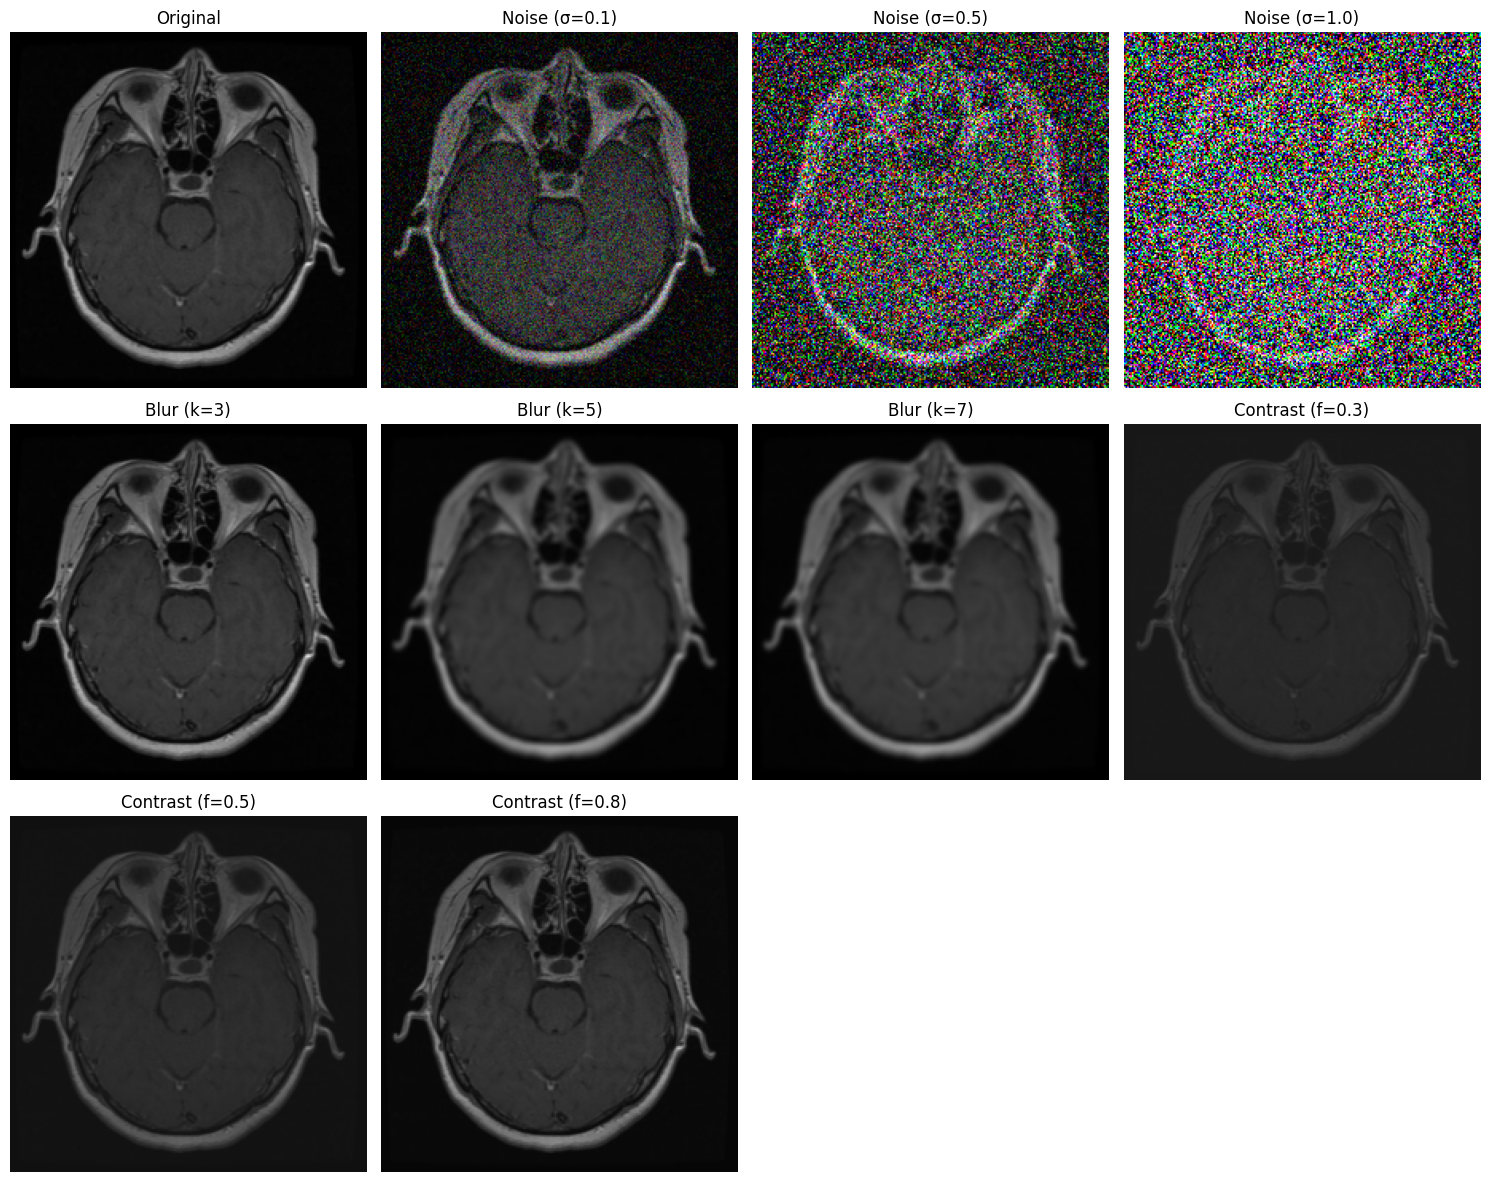

In [3]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import numpy as np

# Define the path to the dataset
base_path = os.path.expanduser("./classification_task")
test_dir = os.path.join(base_path, "test")

# Helper class for Gaussian Noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Function to get a random image
def get_random_image(root_dir):
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    if not classes:
        raise ValueError(f"No classes found in {root_dir}")
    
    random_class = random.choice(classes)
    class_path = os.path.join(root_dir, random_class)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not images:
        raise ValueError(f"No images found in {class_path}")
        
    image_path = os.path.join(class_path, random.choice(images))
    return Image.open(image_path).convert('RGB'), random_class

# Get a sample image
try:
    original_img, label = get_random_image(test_dir)
    print(f"Selected image from class: {label}")
except Exception as e:
    print(f"Error loading image: {e}")
    # Fallback to creating a dummy image if path is wrong
    original_img = Image.fromarray(np.uint8(np.random.rand(224, 224, 3) * 255))
    print("Using dummy image.")

# Base transforms
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
resize = transforms.Resize((224, 224))

img_tensor = to_tensor(resize(original_img))

# Define transformations
transformations = {
    'Original': img_tensor,
}

# Gaussian Noise
for sigma in [0.1, 0.5, 1.0]:
    noisy_tensor = AddGaussianNoise(0., sigma)(img_tensor.clone())
    noisy_tensor = torch.clamp(noisy_tensor, 0, 1)
    transformations[f'Noise (σ={sigma})'] = noisy_tensor

# Blur
for k in [3, 5, 7]:
    blur_transform = transforms.GaussianBlur(kernel_size=k)
    blurred_tensor = blur_transform(img_tensor.clone())
    transformations[f'Blur (k={k})'] = blurred_tensor

# Contrast
for f in [0.3, 0.5, 0.8]:
    contrast_transform = transforms.ColorJitter(contrast=(f, f))
    contrast_tensor = contrast_transform(img_tensor.clone())
    transformations[f'Contrast (f={f})'] = contrast_tensor

# Plotting
num_imgs = len(transformations)
cols = 4
rows = (num_imgs + cols - 1) // cols

plt.figure(figsize=(15, 4 * rows))
for i, (name, tensor) in enumerate(transformations.items()):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(to_pil(tensor))
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()